# Association and Feature Selection

Computing the association between variables is a fundamental aspect of data analysis, enabling us to understand the relationships and dependencies among different data features. 
In this context, we introduce a suite of functions designed to calculate various types of associations, specifically tailored for different combinations of data types—categorical-categorical, numerical-numerical, and categorical-numerical. 
Whether you are exploring correlations in continuous data or examining the dependencies in categorical data, these functions offer a robust toolkit for delving into the intricate web of relationships that exist within your data, providing valuable insights for both exploratory data analysis and predictive modeling.

The computations are also parallelized, initiating a process (CPU-bound) for handling a batch of columns from the pandas DataFrame if the size justifies it. Note that the _first_ call, when using `n_jobs > 1`, may be slow due to the overhead associated with starting the processes. For data of moderate size, setting `n_jobs=1` is usually faster.

Lastly, you have the flexibility to use custom functions to compute associations between columns. These associations can be effectively utilized for feature elimination in the CollinearityThreshold selector.

## Default association functions 

 - Numerical-numerical: Spearman correlation coefficient, symmetric
 - Nominal-Numerical: correlation coefficient, symmetric but the implementation requires the first argument to be the nominal column
 - Nominal-Nominal: Theil's U statistic, asymmetric

In [2]:
import pandas as pd
import numpy as np

from arfs.utils import load_data
from arfs.feature_selection.unsupervised import CollinearityThreshold
from arfs.association import asymmetric_function, xy_to_matrix
from arfs.association import (
    association_matrix,
    correlation_ratio_matrix,
    _callable_association_matrix_fn,
    correlation_ratio,
    weighted_corr,
    wcorr_matrix,
    theils_u_matrix,
    weighted_theils_u,
    association_series,
    _callable_association_series_fn,
)

In [3]:
titanic = load_data(name="Titanic")
X, y = titanic.data, titanic.target
y = y.astype(int)
X.head()

,pclass,sex,embarked,random_cat,is_alone,title,age,family_size,fare,random_num
0,1,female,S,Fry,1,Mrs,29.0000,0.0,211.3375,0.496714
1,1,male,S,Bender,0,Master,0.9167,3.0,151.5500,-0.138264
2,1,female,S,Thanos,0,Mrs,2.0000,3.0,151.5500,0.647689
3,1,male,S,Morty,0,Mr,30.0000,3.0,151.5500,1.523030
4,1,female,S,Morty,0,Mrs,25.0000,3.0,151.5500,-0.234153


## Association series and matrix

Compute the association series and matrix, for all dtypes

In [4]:
association_series(
    X=X,
    target="age",
    normalize=False,
    n_jobs=1,
    handle_na="drop",
)

age            1.000000
title          0.403618
pclass         0.375524
is_alone       0.222841
fare           0.163930
embarked       0.098631
sex            0.057398
random_cat     0.037237
random_num    -0.035203
family_size   -0.139715
dtype: float64

In [5]:
assoc_m = association_matrix(X=X, n_jobs=1)
assoc_m

,row,col,val
0,family_size,fare,0.520323
1,fare,family_size,0.520323
2,age,fare,0.163930
3,fare,age,0.163930
4,family_size,random_num,-0.007552
...,...,...,...
85,sex,random_cat,0.002444
86,random_cat,pclass,0.002035
87,random_cat,is_alone,0.001386
88,pclass,is_alone,0.001314


You can reshape it as

In [6]:
xy_to_matrix(assoc_m)

,age,embarked,family_size,fare,is_alone,pclass,random_cat,random_num,sex,title
age,0.000000,0.098631,-0.139715,0.163930,0.222841,0.375524,0.037237,-0.035203,0.057398,0.403618
embarked,0.098631,0.000000,0.104125,0.300998,0.006505,0.100167,0.006122,0.052706,0.011014,0.012525
family_size,-0.139715,0.104125,0.000000,0.520323,0.785592,0.059053,0.064754,-0.007552,0.188583,0.438517
fare,0.163930,0.300998,0.520323,0.000000,0.175140,0.602869,0.070161,-0.065805,0.185484,0.196217
is_alone,0.222841,0.010056,0.785592,0.175140,0.000000,0.002527,0.005153,0.010023,0.031810,0.172022
pclass,0.375524,0.080502,0.059053,0.602869,0.001314,0.000000,0.003934,0.052158,0.007678,0.029489
random_cat,0.037237,0.002545,0.064754,0.070161,0.001386,0.002035,0.000000,0.064163,0.000818,0.002632
random_num,-0.035203,0.052706,-0.007552,-0.065805,0.010023,0.052158,0.064163,0.000000,0.045685,0.066008
sex,0.057398,0.013678,0.188583,0.185484,0.025554,0.011864,0.002444,0.045685,0.000000,0.976945
title,0.403618,0.010986,0.438517,0.196217,0.097605,0.032183,0.005553,0.066008,0.690022,0.000000


## User defined association functions

The functions `association_series` and `association_matrix` call utilities for computing values using parallelization (if `n_jobs > 1`) : `_callable_association_series_fn` and `_callable_association_matrix_fn`. Those two functions handle the parallelization of generic functions computing association coefficients. 

However the input functions must have a well defined structure:

```python
@symmetric_function
def input_function_computing_coefficient_values(x, y, sample_weight=None, as_frame=True):
    """
    Calculate the [DESCRIPTION HERE] for series x with respect to series y.

    Parameters
    ----------
    x : pandas.Series
        A pandas Series representing a feature.
    y : pandas.Series
        Another pandas Series representing a feature.
    as_frame : bool, optional
        If True, the function returns the result as a pandas DataFrame;
        otherwise, it returns a float value. The default is False.

    Returns
    -------
    Union[float, pandas.DataFrame]
        A score representing the [COEFFICIENT NAME] between x and y. 
        If `as_frame` is True, returns a DataFrame with the columns "row", "col", and "val",
        where "row" and "col" represent the names of the series x and y, respectively, 
        and "val" is the PPS score. If `as_frame` is False, returns the PPS score as a float.
    """
    
    if x.name == y.name:
        score = 1
    else: 
        df = pd.DataFrame({"x": x.values, "y": y.values})
        # Calculating the PPS and extracting the score
        [CUSTOM CODE HERE, RETURNING THE COEFFICIENT VALUE c]
    
    if as_frame:
        # Symmetry allows to not compute twice the same quantity
        return pd.DataFrame(
            {"row": [x_name, y_name], "col": [y_name, x_name], "val": [v, v]}
        )
    else:
        return c
```

for asymmetric association coefficient, as Theil's U statistic

```python
@asymmetric_function
def input_function_computing_coefficient_values(x, y, sample_weight=None, as_frame=True):
    """
    Calculate the [DESCRIPTION HERE] for series x with respect to series y.

    Parameters
    ----------
    x : pandas.Series
        A pandas Series representing a feature.
    y : pandas.Series
        Another pandas Series representing a feature.
    as_frame : bool, optional
        If True, the function returns the result as a pandas DataFrame;
        otherwise, it returns a float value. The default is False.

    Returns
    -------
    Union[float, pandas.DataFrame]
        A score representing the [COEFFICIENT NAME] between x and y. 
        If `as_frame` is True, returns a DataFrame with the columns "row", "col", and "val",
        where "row" and "col" represent the names of the series x and y, respectively, 
        and "val" is the PPS score. If `as_frame` is False, returns the PPS score as a float.
    """
    
    if x.name == y.name:
        score = 1
    else: 
        df = pd.DataFrame({"x": x.values, "y": y.values})
        # Calculating the PPS and extracting the score
        [CUSTOM CODE HERE, RETURNING THE COEFFICIENT VALUE c]
    
    if as_frame:
        return pd.DataFrame({"row": x.name, "col": y.name, "val":c}, index=[0])
    else:
        return c
```

### Example

In [7]:
import ppscore as pps


@asymmetric_function
def ppscore_arfs(x, y, sample_weight=None, as_frame=True):
    """
    Calculate the Predictive Power Score (PPS) for series x with respect to series y.

    The PPS is a score that shows the predictive relationship between two variables.
    This function calculates the PPS of x predicting y. If the series have the same name,
    the function assumes they are identical and returns a score of 1.

    Parameters
    ----------
    x : pandas.Series
        A pandas Series representing a feature.
    y : pandas.Series
        Another pandas Series representing a feature.
    as_frame : bool, optional
        If True, the function returns the result as a pandas DataFrame;
        otherwise, it returns a float value. The default is False.

    Returns
    -------
    Union[float, pandas.DataFrame]
        A score representing the PPS between x and y.
        If `as_frame` is True, returns a DataFrame with the columns "row", "col", and "val",
        where "row" and "col" represent the names of the series x and y, respectively,
        and "val" is the PPS score. If `as_frame` is False, returns the PPS score as a float.
    """

    # Merging x and y into a single DataFrame

    # Ensure x and y are DataFrames with only one column
    if (
        isinstance(x, pd.DataFrame)
        and isinstance(y, pd.DataFrame)
        and x.shape[1] == 1
        and y.shape[1] == 1
    ):
        # Extracting the series from the DataFrames
        x = x.iloc[:, 0]
        y = y.iloc[:, 0]

    if x.name == y.name:
        score = 1
    else:
        df = pd.DataFrame({"x": x.values, "y": y.values})
        # Calculating the PPS and extracting the score
        score = pps.score(df, df.columns[0], df.columns[1])["ppscore"]

    if as_frame:
        return pd.DataFrame({"row": x.name, "col": y.name, "val": score}, index=[0])
    else:
        return score

In [8]:
d = association_matrix(
    X=X,
    n_jobs=1,
    nom_nom_assoc=ppscore_arfs,
    num_num_assoc=ppscore_arfs,
    nom_num_assoc=ppscore_arfs,
)

xy_to_matrix(d)

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.

,age,embarked,family_size,fare,is_alone,pclass,random_cat,random_num,sex,title
age,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
embarked,0.00000,0.000000,0.000000,0.000000,0.000000,0.132714,0.0,0.000000,0.000000,0.000000
family_size,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
fare,0.00000,0.000000,0.603721,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
is_alone,0.00000,0.000012,0.324128,0.000000,0.000000,0.000000,0.0,0.000000,0.166500,0.208732
pclass,0.00000,0.000012,0.000000,0.188409,0.000000,0.000000,0.0,0.000606,0.000000,0.000000
random_cat,0.00000,0.000012,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
random_num,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
sex,0.00000,0.000012,0.000000,0.000000,0.000000,0.000000,0.0,0.001554,0.000000,0.796922
title,0.04168,0.000012,0.000000,0.000000,0.267387,0.000000,0.0,0.001815,0.984495,0.000000


# Link to feature selection

The `CollinearityThreshold` selector of the `arfs.feature_selection.unsupervised` module uses the association matrix behind the scene. You can replace the default functions by your user defined one:

In [9]:
selector = CollinearityThreshold(
    method="association",
    nom_nom_assoc=ppscore_arfs,
    num_num_assoc=ppscore_arfs,
    nom_num_assoc=ppscore_arfs,
    threshold=0.5,
).fit(X)

print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/home/bsatom/Documents/arfs_test_nbs/arfsuv/lib/python3.12/site-packages/sklearn/model_selection/_split.

The features going in the selector are : ['pclass' 'sex' 'embarked' 'random_cat' 'is_alone' 'title' 'age'
 'family_size' 'fare' 'random_num']
The support is : [ True  True  True  True  True False  True False  True  True]
The selected features are : ['pclass' 'sex' 'embarked' 'random_cat' 'is_alone' 'age' 'fare'
 'random_num']


In [10]:
selector.assoc_matrix_

,age,embarked,family_size,fare,is_alone,pclass,random_cat,random_num,sex,title
age,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
embarked,0.00000,0.000000,0.000000,0.000000,0.000000,0.132714,0.0,0.000000,0.000000,0.000000
family_size,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
fare,0.00000,0.000000,0.603721,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
is_alone,0.00000,0.000012,0.324128,0.000000,0.000000,0.000000,0.0,0.000000,0.166500,0.208732
pclass,0.00000,0.000012,0.000000,0.188409,0.000000,0.000000,0.0,0.000606,0.000000,0.000000
random_cat,0.00000,0.000012,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
random_num,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
sex,0.00000,0.000012,0.000000,0.000000,0.000000,0.000000,0.0,0.001554,0.000000,0.796922
title,0.04168,0.000012,0.000000,0.000000,0.267387,0.000000,0.0,0.001815,0.984495,0.000000


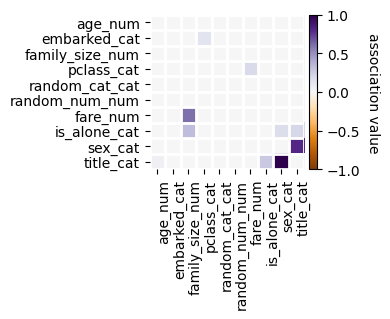

In [11]:
f = selector.plot_association(figsize=(4, 4))